<a href="https://colab.research.google.com/github/mrezajbh/CO2CAPTURE/blob/main/newtea.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

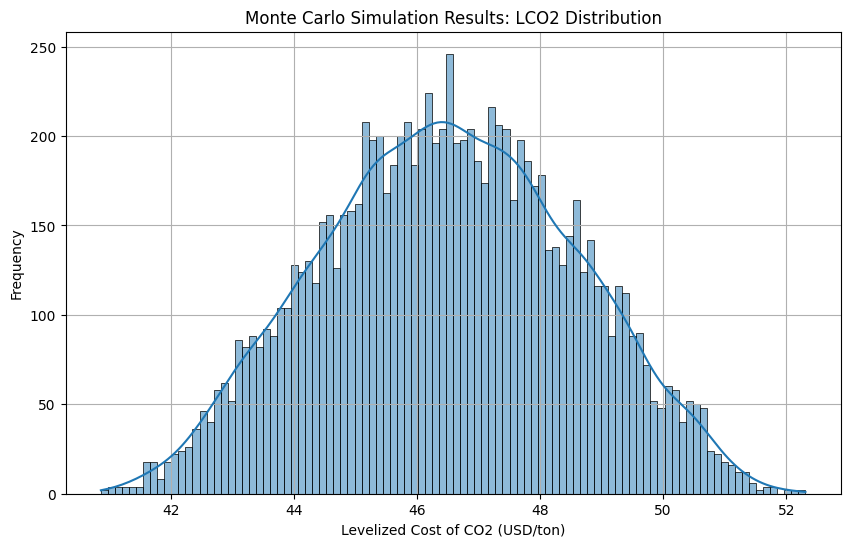

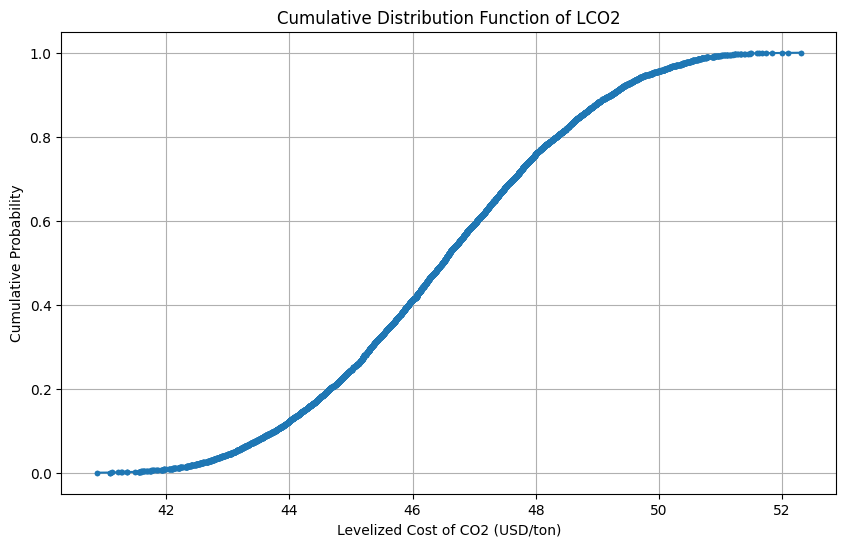

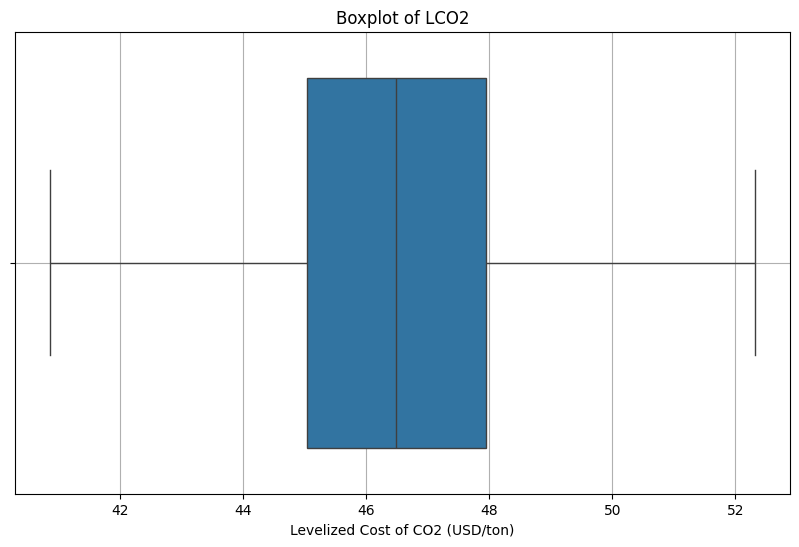

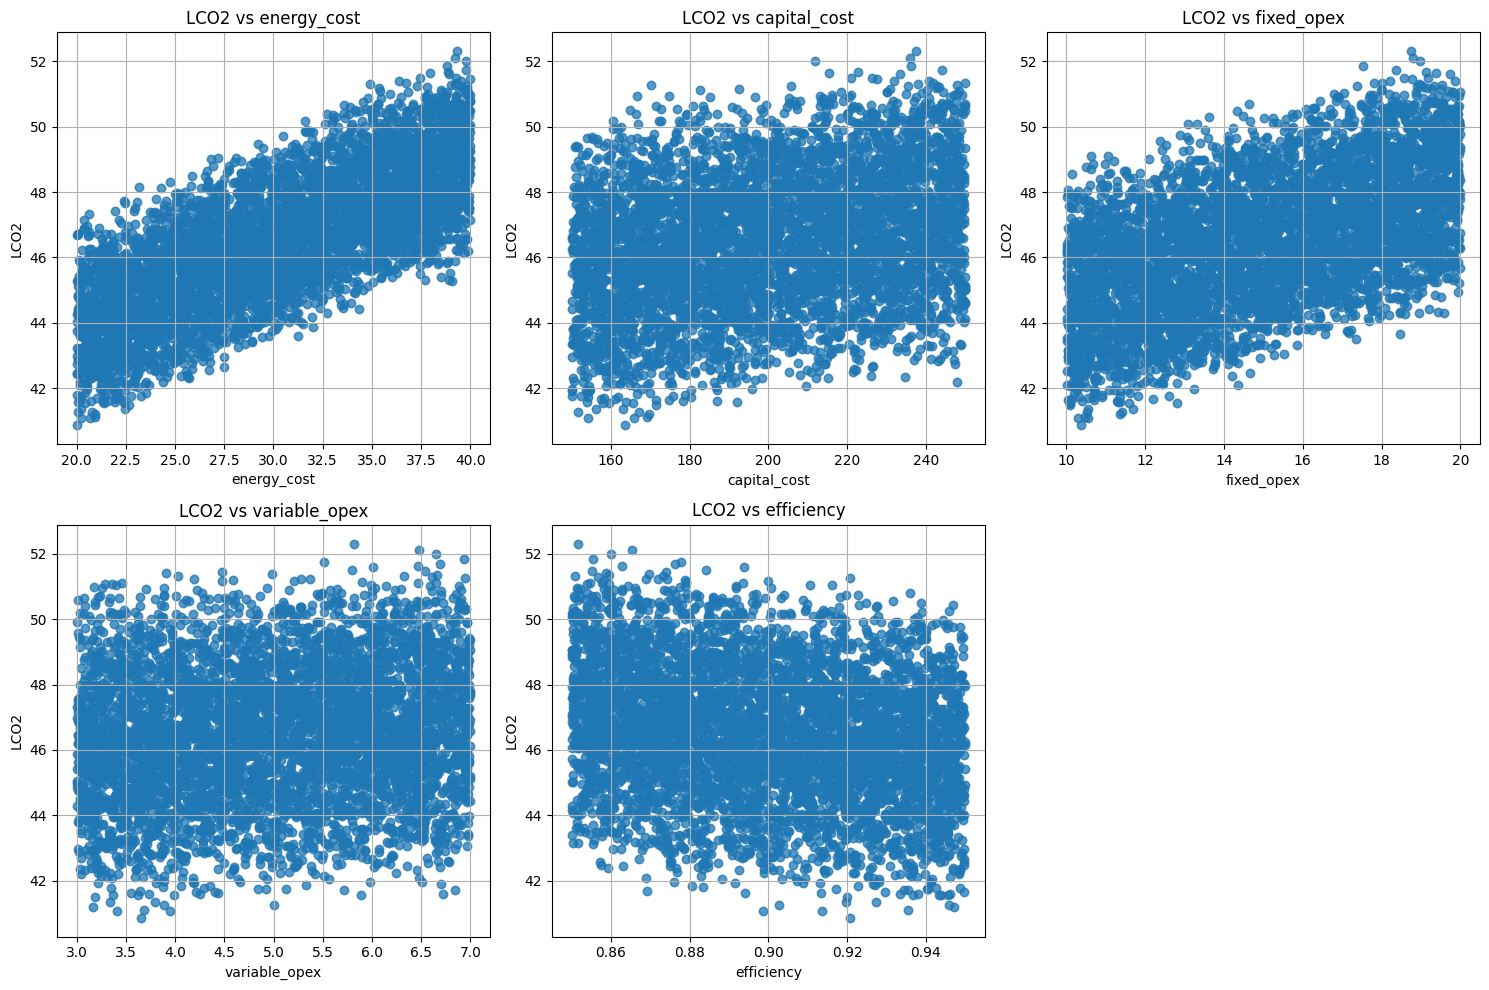

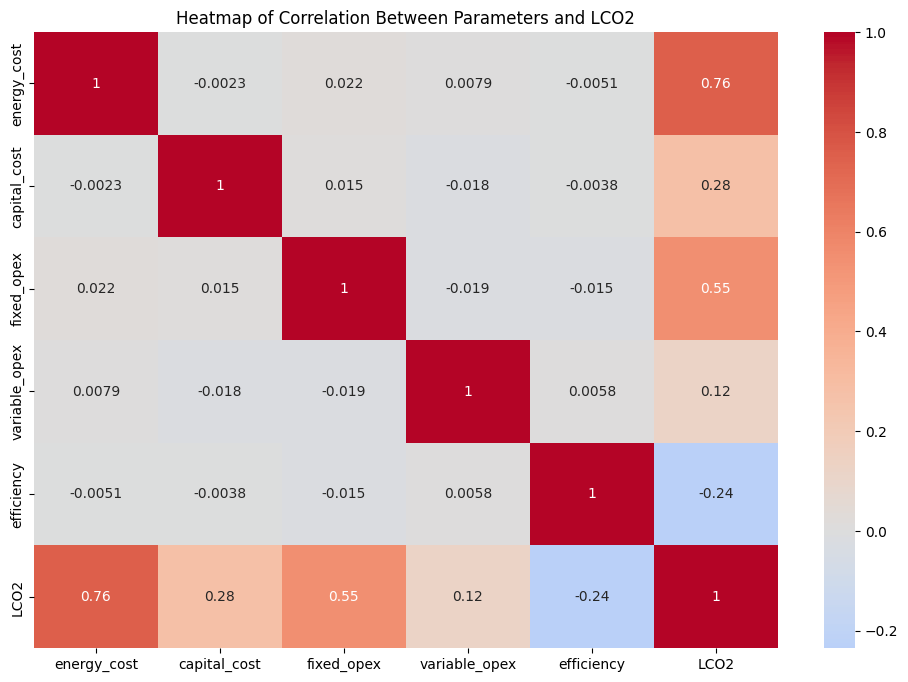

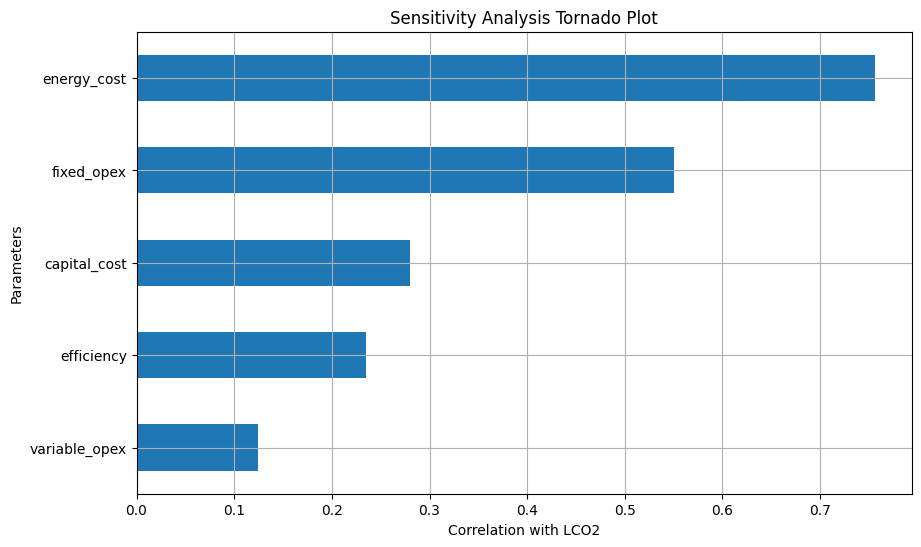

Monte Carlo Simulation Results:
count    10000.000000
mean        46.492103
std          2.045187
min         40.866345
25%         45.035712
50%         46.493185
75%         47.951974
max         52.311695
Name: LCO2, dtype: float64

Comparison of Capture Technologies:
post_combustion: $46.45 per ton CO2
pre_combustion: $46.31 per ton CO2
oxy_fuel: $48.20 per ton CO2
direct_air_capture: $56.34 per ton CO2


<ipython-input-3-7a6eb0c4e006>:308: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tech_names, y=tech_costs, palette='viridis')


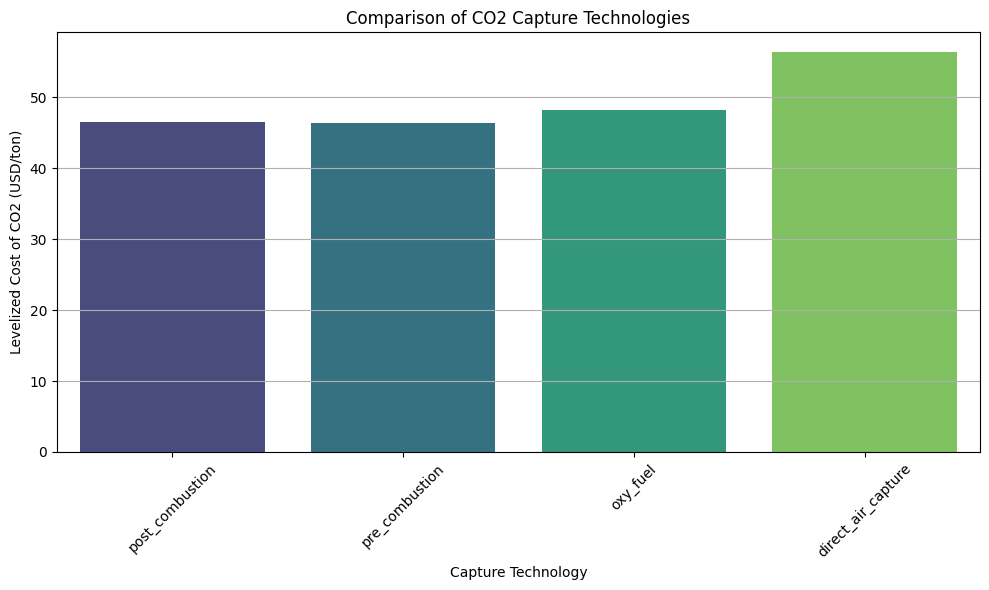


Cost per ton of CO2 captured: $34.56

Total cost: $1,261,654,574.15
Total CO2 captured: 36,511,271.28 tons
Total avoided emissions: 17,160,297.50 tons
Error occurred during analysis of project_lifetime at value 10.0: expected a sequence of integers or a single integer, got '10.0'
Error occurred during analysis of project_lifetime at value 17.5: expected a sequence of integers or a single integer, got '17.5'
Error occurred during analysis of project_lifetime at value 25.0: expected a sequence of integers or a single integer, got '25.0'
Error occurred during analysis of project_lifetime at value 32.5: expected a sequence of integers or a single integer, got '32.5'
Error occurred during analysis of project_lifetime at value 40.0: expected a sequence of integers or a single integer, got '40.0'


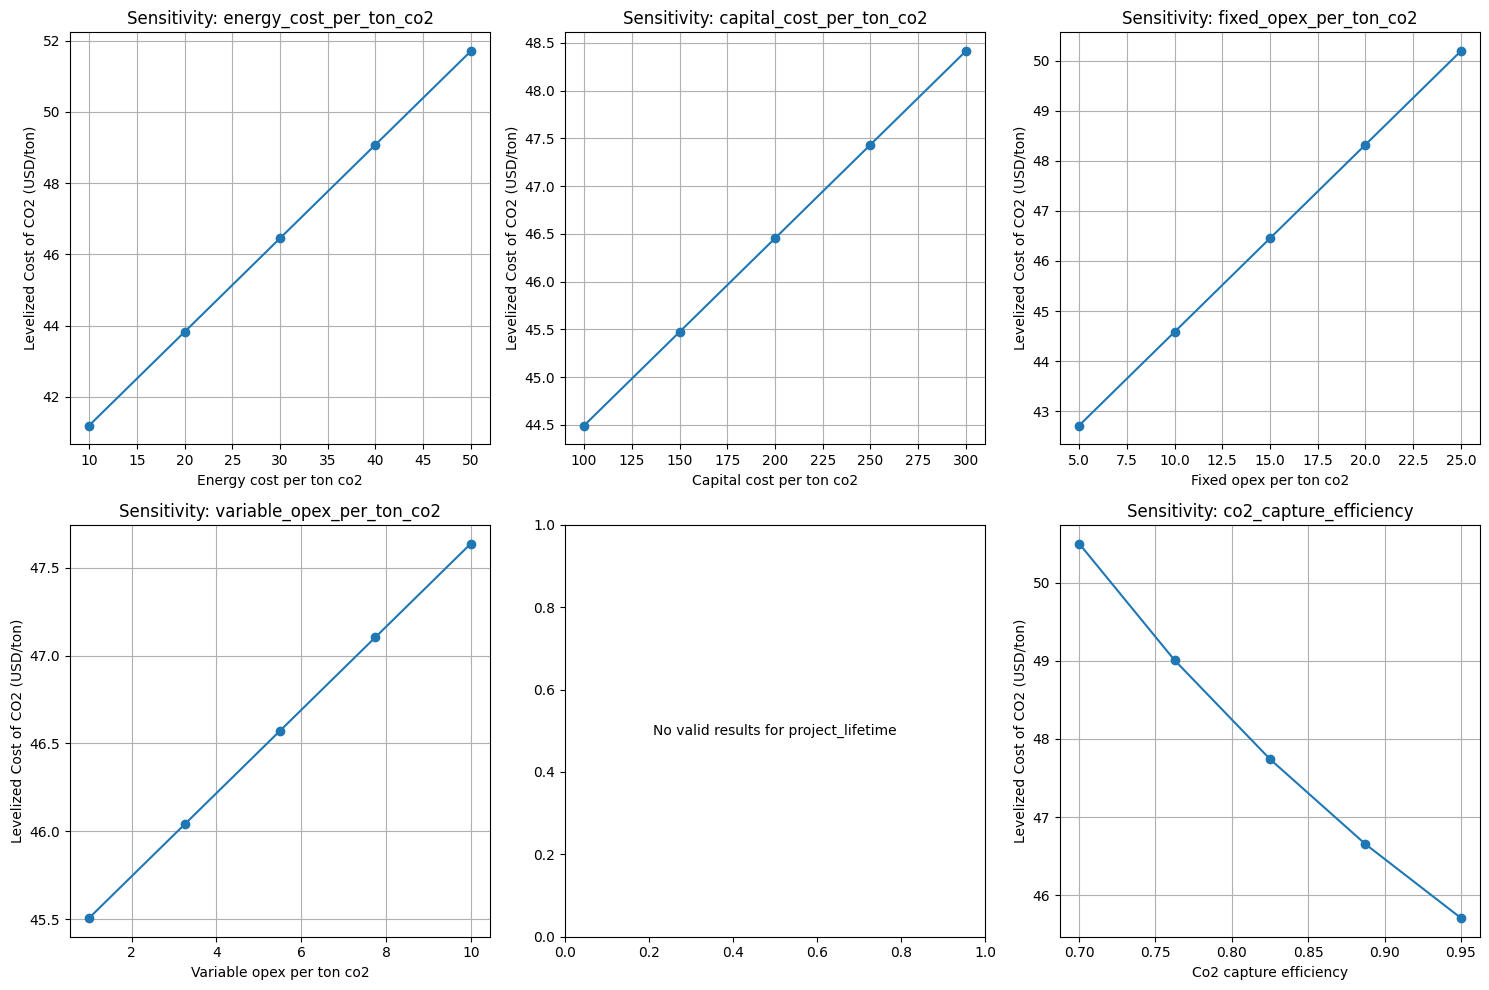

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import uniform
from multiprocessing import Pool

class CO2CaptureCostCalculator:
    def __init__(self, co2_captured_per_year, energy_cost_per_ton_co2, capital_cost_per_ton_co2,
                 fixed_opex_per_ton_co2, variable_opex_per_ton_co2, project_lifetime,
                 co2_capture_efficiency, discount_rate=0.05, inflation_rate=0.02,
                 capture_technology='post_combustion'):
        """
        Initialize the CO2 capture cost calculator with the given parameters.
        """
        # Input validation
        self._validate_inputs(co2_captured_per_year, energy_cost_per_ton_co2, capital_cost_per_ton_co2,
                              fixed_opex_per_ton_co2, variable_opex_per_ton_co2, project_lifetime,
                              co2_capture_efficiency)

        self.co2_captured_per_year = co2_captured_per_year
        self.energy_cost_per_ton_co2 = energy_cost_per_ton_co2
        self.capital_cost_per_ton_co2 = capital_cost_per_ton_co2
        self.fixed_opex_per_ton_co2 = fixed_opex_per_ton_co2
        self.variable_opex_per_ton_co2 = variable_opex_per_ton_co2
        self.project_lifetime = project_lifetime
        self.co2_capture_efficiency = co2_capture_efficiency
        self.discount_rate = discount_rate
        self.inflation_rate = inflation_rate
        self.capture_technology = capture_technology

        # New attributes for different scenarios
        self.energy_mix = {'coal': 0.3, 'natural_gas': 0.4, 'renewable': 0.3}
        self.carbon_intensity = {'coal': 0.9, 'natural_gas': 0.5, 'renewable': 0.0}
        self.technology_improvement_rate = 0.02  # 2% annual improvement in efficiency
        self.maintenance_schedule = [5, 10, 15, 20, 25]  # Years with major maintenance
        self.major_maintenance_cost = 0.1  # 10% of initial capital cost

    def _validate_inputs(self, co2_captured, energy_cost, capital_cost, fixed_opex, variable_opex, lifetime, efficiency):
        """Validate input parameters."""
        if not (50000 <= co2_captured <= 5000000):
            raise ValueError("CO2 captured per year should be between 50,000 and 5,000,000 tons.")
        if not (10 <= energy_cost <= 600):
            raise ValueError("Energy cost per ton of CO2 should be between 10 and 600 USD.")
        if not (50 <= capital_cost <= 300):
            raise ValueError("Capital cost per ton of CO2 should be between 50 and 300 USD.")
        if not (5 <= fixed_opex <= 25):
            raise ValueError("Fixed OPEX per ton of CO2 should be between 5 and 25 USD.")
        if not (1 <= variable_opex <= 10):
            raise ValueError("Variable OPEX per ton of CO2 should be between 1 and 10 USD.")
        if not (10 <= lifetime <= 40):
            raise ValueError("Project lifetime should be between 10 and 40 years.")
        if not (0.7 <= efficiency <= 0.95):
            raise ValueError("CO2 capture efficiency should be between 0.7 and 0.95.")

    def calculate_total_cost_and_co2_captured(self):
        """
        Calculate the total cost and CO2 captured over the project lifetime.
        """
        years = np.arange(self.project_lifetime)
        discount_factors = 1 / (1 + self.discount_rate) ** years
        inflation_factors = (1 + self.inflation_rate) ** years

        avg_carbon_intensity = sum(self.energy_mix[source] * self.carbon_intensity[source] for source in self.energy_mix)

        annual_energy_cost = (self.co2_captured_per_year * self.energy_cost_per_ton_co2
                              * (1 + 0.01 * years) * (1 - self.technology_improvement_rate) ** years)
        annual_fixed_opex = (self.fixed_opex_per_ton_co2 * self.co2_captured_per_year
                             * (1 + 0.02 * years))
        annual_variable_opex = (self.variable_opex_per_ton_co2 * self.co2_captured_per_year
                                * (1 - self.technology_improvement_rate) ** years)

        maintenance_costs = np.zeros(self.project_lifetime)
        for year in self.maintenance_schedule:
            if year < self.project_lifetime:
                maintenance_costs[year] = (self.capital_cost_per_ton_co2 * self.co2_captured_per_year
                                           * self.major_maintenance_cost)

        annual_costs = (annual_energy_cost + annual_fixed_opex + annual_variable_opex + maintenance_costs)

        discounted_costs = annual_costs * discount_factors * inflation_factors
        total_operational_cost = discounted_costs.sum()

        total_capital_cost = self.co2_captured_per_year * self.capital_cost_per_ton_co2
        total_cost = total_capital_cost + total_operational_cost

        annual_co2_captured = (self.co2_captured_per_year * self.co2_capture_efficiency
                               * (1 + self.technology_improvement_rate) ** years)
        total_co2_captured = annual_co2_captured.sum()

        total_avoided_emissions = total_co2_captured * avg_carbon_intensity

        return total_cost, total_co2_captured, total_avoided_emissions

    def calculate_cost_per_ton_co2(self):
        """
        Calculate the cost per ton of CO2 captured.
        """
        total_cost, total_co2_captured, _ = self.calculate_total_cost_and_co2_captured()
        return total_cost / total_co2_captured if total_co2_captured > 0 else float('inf')

class CO2SensitivityAnalysis:
    def __init__(self, calculator, co2_sale_price_per_ton=50,
                 co2_sale_percentage=0.8, carbon_tax=100, tax_credit_percentage=0.2,
                 learning_rate=0.10, carbon_tax_threshold=100000):
        """
        Initialize the CO2 sensitivity analysis with the given parameters.
        """
        self.calculator = calculator
        self.co2_sale_price_per_ton = co2_sale_price_per_ton
        self.co2_sale_percentage = co2_sale_percentage
        self.carbon_tax = carbon_tax
        self.tax_credit_percentage = tax_credit_percentage
        self.learning_rate = learning_rate
        self.carbon_tax_threshold = carbon_tax_threshold

    def analyze_parameter(self, parameters, range_values):
        """
        Analyze the sensitivity of the cost per ton of CO2 to different parameters.
        """
        original_values = {param: getattr(self, param) if hasattr(self, param) else getattr(self.calculator, param) for param in parameters}
        results = {param: [] for param in parameters}

        for param, values in zip(parameters, range_values):
            for value in values:
                try:
                    if hasattr(self, param):
                        setattr(self, param, value)
                    else:
                        setattr(self.calculator, param, value)
                    lco2 = self.calculate_levelized_cost_of_co2()
                    results[param].append(lco2)
                except Exception as e:
                    print(f"Error occurred during analysis of {param} at value {value}: {e}")

            # Reset the parameter to its original value
            setattr(self, param, original_values[param]) if hasattr(self, param) else setattr(self.calculator, param, original_values[param])

        return results

    def calculate_levelized_cost_of_co2(self):
        """
        Calculate the levelized cost of CO2 captured.
        """
        years = np.arange(self.calculator.project_lifetime)
        discount_factors = 1 / (1 + self.calculator.discount_rate) ** years

        total_cost, total_co2_captured, _ = self.calculator.calculate_total_cost_and_co2_captured()
        annual_co2_captured = total_co2_captured / self.calculator.project_lifetime

        annual_costs = total_cost / self.calculator.project_lifetime
        annual_revenue = annual_co2_captured * self.co2_sale_price_per_ton * self.co2_sale_percentage
        annual_tax = max(0, annual_co2_captured - self.carbon_tax_threshold) * self.carbon_tax
        tax_credit = self.calculator.capital_cost_per_ton_co2 * self.calculator.co2_captured_per_year * self.tax_credit_percentage

        cumulative_co2_captured = np.cumsum(annual_co2_captured)
        annual_variable_opex_learning = self.calculator.variable_opex_per_ton_co2 * (cumulative_co2_captured / self.calculator.co2_captured_per_year) ** (-self.learning_rate)

        net_annual_costs = (annual_costs - annual_revenue + annual_tax - annual_variable_opex_learning)
        discounted_annual_costs = net_annual_costs * discount_factors

        levelized_cost_of_co2 = discounted_annual_costs.sum() / total_co2_captured

        return levelized_cost_of_co2

    def monte_carlo_simulation(self, num_simulations=1000):
        """
        Perform a Monte Carlo simulation to estimate the distribution of the levelized cost of CO2.
        """
        results = []
        for _ in range(num_simulations):
            self.calculator.energy_cost_per_ton_co2 = uniform.rvs(20, 20)
            self.calculator.capital_cost_per_ton_co2 = uniform.rvs(150, 100)
            self.calculator.fixed_opex_per_ton_co2 = uniform.rvs(10, 10)
            self.calculator.variable_opex_per_ton_co2 = uniform.rvs(3, 4)
            self.calculator.co2_capture_efficiency = uniform.rvs(0.85, 0.10)

            lco2 = self.calculate_levelized_cost_of_co2()
            results.append(lco2)

        return pd.Series(results).describe()

class EnhancedCO2SensitivityAnalysis(CO2SensitivityAnalysis):
    def __init__(self, calculator, num_simulations=10000):
        super().__init__(calculator)
        self.num_simulations = num_simulations

    def run_single_simulation(self, _):
        self.calculator.energy_cost_per_ton_co2 = uniform.rvs(20, 20)
        self.calculator.capital_cost_per_ton_co2 = uniform.rvs(150, 100)
        self.calculator.fixed_opex_per_ton_co2 = uniform.rvs(10, 10)
        self.calculator.variable_opex_per_ton_co2 = uniform.rvs(3, 4)
        self.calculator.co2_capture_efficiency = uniform.rvs(0.85, 0.10)

        lco2 = self.calculate_levelized_cost_of_co2()
        params = {
            'energy_cost': self.calculator.energy_cost_per_ton_co2,
            'capital_cost': self.calculator.capital_cost_per_ton_co2,
            'fixed_opex': self.calculator.fixed_opex_per_ton_co2,
            'variable_opex': self.calculator.variable_opex_per_ton_co2,
            'efficiency': self.calculator.co2_capture_efficiency
        }
        return lco2, params

    def perform_monte_carlo_simulation(self):
        with Pool() as pool:
            results = pool.map(self.run_single_simulation, range(self.num_simulations))

        lco2s, params = zip(*results)
        results_df = pd.DataFrame(lco2s, columns=['LCO2'])
        params_df = pd.DataFrame(params)
        return results_df, params_df

    def plot_monte_carlo_results(self, results_df):
        plt.figure(figsize=(10, 6))
        sns.histplot(results_df['LCO2'], bins=100, kde=True)
        plt.title('Monte Carlo Simulation Results: LCO2 Distribution')
        plt.xlabel('Levelized Cost of CO2 (USD/ton)')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()

    def plot_cumulative_lco2(self, results_df):
        plt.figure(figsize=(10, 6))
        sorted_lco2 = np.sort(results_df['LCO2'])
        cumulative_prob = np.linspace(0, 1, len(sorted_lco2))
        plt.plot(sorted_lco2, cumulative_prob, marker='.')
        plt.title('Cumulative Distribution Function of LCO2')
        plt.xlabel('Levelized Cost of CO2 (USD/ton)')
        plt.ylabel('Cumulative Probability')
        plt.grid(True)
        plt.show()

    def plot_lco2_boxplot(self, results_df):
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=results_df['LCO2'])
        plt.title('Boxplot of LCO2')
        plt.xlabel('Levelized Cost of CO2 (USD/ton)')
        plt.grid(True)
        plt.show()

    def plot_lco2_vs_parameters(self, params_df, results_df):
        plt.figure(figsize=(15, 10))
        for i, column in enumerate(params_df.columns, 1):
            plt.subplot(2, 3, i)
            plt.scatter(params_df[column], results_df['LCO2'], alpha=0.5)
            plt.xlabel(column)
            plt.ylabel('LCO2')
            plt.title(f'LCO2 vs {column}')
            plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plot_heatmap_lco2_vs_parameters(self, params_df, results_df):
        correlation_matrix = params_df.assign(LCO2=results_df['LCO2']).corr()
        plt.figure(figsize=(12, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
        plt.title('Heatmap of Correlation Between Parameters and LCO2')
        plt.show()

    def plot_sensitivity_tornado(self, params_df, results_df):
        correlations = params_df.corrwith(results_df['LCO2'])
        correlations_sorted = correlations.abs().sort_values()
        plt.figure(figsize=(10, 6))
        correlations_sorted.plot(kind='barh')
        plt.title('Sensitivity Analysis Tornado Plot')
        plt.xlabel('Correlation with LCO2')
        plt.ylabel('Parameters')
        plt.grid(True)
        plt.show()

def compare_capture_technologies():
    """
    Compare the levelized cost of CO2 captured across different capture technologies.
    """
    technologies = {
        'post_combustion': {'efficiency': 0.9, 'energy_cost': 30, 'capital_cost': 200},
        'pre_combustion': {'efficiency': 0.85, 'energy_cost': 25, 'capital_cost': 220},
        'oxy_fuel': {'efficiency': 0.92, 'energy_cost': 35, 'capital_cost': 240},
        'direct_air_capture': {'efficiency': 0.8, 'energy_cost': 50, 'capital_cost': 300}
    }

    results = {}
    for tech, params in technologies.items():
        calculator = CO2CaptureCostCalculator(
            co2_captured_per_year=1000000,
            energy_cost_per_ton_co2=params['energy_cost'],
            capital_cost_per_ton_co2=params['capital_cost'],
            fixed_opex_per_ton_co2=15,
            variable_opex_per_ton_co2=5,
            project_lifetime=30,
            co2_capture_efficiency=params['efficiency'],
            capture_technology=tech
        )
        sensitivity_analysis = CO2SensitivityAnalysis(calculator)
        results[tech] = sensitivity_analysis.calculate_levelized_cost_of_co2()

    return results

def plot_technology_comparison(tech_comparison):
    """
    Plot a comparison of different CO2 capture technologies.
    """
    tech_names = list(tech_comparison.keys())
    tech_costs = list(tech_comparison.values())

    plt.figure(figsize=(10, 6))
    sns.barplot(x=tech_names, y=tech_costs, palette='viridis')
    plt.xlabel("Capture Technology")
    plt.ylabel("Levelized Cost of CO2 (USD/ton)")
    plt.title("Comparison of CO2 Capture Technologies")
    plt.xticks(rotation=45)
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    # Create a calculator instance
    calculator = CO2CaptureCostCalculator(
        co2_captured_per_year=1000000,
        energy_cost_per_ton_co2=30,
        capital_cost_per_ton_co2=200,
        fixed_opex_per_ton_co2=15,
        variable_opex_per_ton_co2=5,
        project_lifetime=30,
        co2_capture_efficiency=0.9
    )

    # Create an enhanced sensitivity analysis instance
    enhanced_sensitivity_analysis = EnhancedCO2SensitivityAnalysis(calculator)

    # Perform Monte Carlo simulation
    results_df, params_df = enhanced_sensitivity_analysis.perform_monte_carlo_simulation()

    # Plot results
    enhanced_sensitivity_analysis.plot_monte_carlo_results(results_df)
    enhanced_sensitivity_analysis.plot_cumulative_lco2(results_df)
    enhanced_sensitivity_analysis.plot_lco2_boxplot(results_df)
    enhanced_sensitivity_analysis.plot_lco2_vs_parameters(params_df, results_df)
    enhanced_sensitivity_analysis.plot_heatmap_lco2_vs_parameters(params_df, results_df)
    enhanced_sensitivity_analysis.plot_sensitivity_tornado(params_df, results_df)

    # Print summary statistics
    print("Monte Carlo Simulation Results:")
    print(results_df['LCO2'].describe())

    # Compare different capture technologies
    tech_comparison = compare_capture_technologies()
    print("\nComparison of Capture Technologies:")
    for tech, cost in tech_comparison.items():
        print(f"{tech}: ${cost:.2f} per ton CO2")
    plot_technology_comparison(tech_comparison)

    # Calculate and print the cost per ton of CO2 for the main calculator
    cost_per_ton = calculator.calculate_cost_per_ton_co2()
    print(f"\nCost per ton of CO2 captured: ${cost_per_ton:.2f}")

    # Calculate and print total cost, CO2 captured, and avoided emissions
    total_cost, total_co2_captured, total_avoided_emissions = calculator.calculate_total_cost_and_co2_captured()
    print(f"\nTotal cost: ${total_cost:,.2f}")
    print(f"Total CO2 captured: {total_co2_captured:,.2f} tons")
    print(f"Total avoided emissions: {total_avoided_emissions:,.2f} tons")

    # Perform sensitivity analysis
    parameters = ['energy_cost_per_ton_co2', 'capital_cost_per_ton_co2', 'fixed_opex_per_ton_co2',
                  'variable_opex_per_ton_co2', 'project_lifetime', 'co2_capture_efficiency']
    range_values = [np.linspace(10, 50, 5), np.linspace(100, 300, 5), np.linspace(5, 25, 5),
                    np.linspace(1, 10, 5), np.linspace(10, 40, 5), np.linspace(0.7, 0.95, 5)]

    sensitivity_results = enhanced_sensitivity_analysis.analyze_parameter(parameters, range_values)

    # Plot sensitivity analysis results
    plt.figure(figsize=(15, 10))
    for i, (param, values) in enumerate(zip(parameters, range_values), 1):
        plt.subplot(2, 3, i)
        if sensitivity_results[param]:  # Only plot if there are results
            plt.plot(values, sensitivity_results[param], marker='o')
            plt.xlabel(param.replace('_', ' ').capitalize())
            plt.ylabel('Levelized Cost of CO2 (USD/ton)')
            plt.title(f'Sensitivity: {param}')
            plt.grid(True)
        else:
            plt.text(0.5, 0.5, f"No valid results for {param}",
                    horizontalalignment='center', verticalalignment='center')
    plt.tight_layout()
    plt.show()